# Curved Spacetime and Covariant Derivatives

This notebook explores the transition from flat Minkowski spacetime to curved spacetime geometry. We'll develop the mathematical machinery needed for general relativistic hydrodynamics, including Christoffel symbols, covariant derivatives, and metric compatibility.

## Learning Objectives
- Understand why curved spacetime is necessary for relativistic physics
- Master Christoffel symbol computation and physical interpretation
- Implement covariant derivatives and validate metric compatibility
- Explore coordinate transformations and general covariance

---

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from typing import List, Tuple, Dict, Any
import warnings

# Configure plotting and symbolic math
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sp.init_printing(use_latex=True)

# Import library components
import sys
sys.path.append('..')

from israel_stewart.core import (
    SpacetimeGrid, MinkowskiMetric, SchwarzschildMetric, GeneralMetric,
    FourVector, CovariantDerivative, TensorField
)

print("Israel-Stewart library loaded successfully!")
print(f"NumPy version: {np.__version__}")
print(f"SymPy version: {sp.__version__}")
print(f"Machine precision: {np.finfo(float).eps:.2e}")

Israel-Stewart library loaded successfully!
NumPy version: 2.2.6
SymPy version: 1.14.0
Machine precision: 2.22e-16


## Section 2.1: Why Curved Spacetime?

### Theory: The Equivalence Principle

Einstein's **equivalence principle** states that gravitational effects are locally indistinguishable from acceleration. This profound insight led to the geometric interpretation of gravity as curvature of spacetime.

**Key insight**: An observer in free fall experiences no gravitational force (weightlessness), while an accelerated observer experiences fictitious forces that mimic gravity.

**Mathematical consequence**: In accelerated or gravitational fields, the flat Minkowski metric $\eta_{\mu\nu}$ must be replaced by a general metric $g_{\mu\nu}(x^\lambda)$ that depends on spacetime coordinates.

Let's demonstrate this with a simple example:

In [8]:
def demonstrate_equivalence_principle():
    """Demonstrate equivalence principle with accelerated observers"""
    
    print("=== Equivalence Principle Demonstration ===")
    
    # Observer accelerating upward with constant acceleration a
    a = 9.8  # m/s² (Earth's surface gravity)
    
    print(f"\nAccelerated observer with a = {a} m/s²")
    print("In the accelerated frame, the effective metric becomes:")
    
    # Time coordinate in accelerated frame
    def effective_metric_component(t, x, acceleration):
        """Effective g_tt component in accelerated frame"""
        # In uniformly accelerated frame: g_tt ≈ -(1 + ax/c²)²
        # For small accelerations and distances
        c = 1  # Natural units
        return -(1 + acceleration * x / c**2)**2
    
    # Test at different positions
    positions = np.array([0, 1, 10, 100])  # meters
    
    print("\nEffective metric component g_tt at different positions:")
    print("Position (m)   g_tt (accelerated)   g_tt (Minkowski)   Difference")
    print("-" * 65)
    
    for x in positions:
        g_tt_acc = effective_metric_component(0, x, a)
        g_tt_flat = -1.0  # Minkowski
        difference = abs(g_tt_acc - g_tt_flat)
        
        print(f"{x:8.0f}      {g_tt_acc:+.6f}           {g_tt_flat:+.6f}        {difference:.6f}")
    
    print("\n🔍 Physical interpretation:")
    print("• Acceleration creates position-dependent time dilation")
    print("• Higher positions experience faster time flow")
    print("• This is identical to gravitational redshift!")
    print("• Therefore: acceleration ≡ gravity (locally)")
    
    # Demonstrate tidal effects
    print("\n=== Tidal Effects (Curvature Signature) ===")
    
    # In true gravity, tidal forces reveal curvature
    # Schwarzschild metric near Earth's surface
    R_earth = 6.37e6  # meters
    rs_earth = 8.87e-3  # Schwarzschild radius for Earth (meters)
    
    def tidal_acceleration(height):
        """Tidal acceleration difference over height h"""
        # Simplified: d²h/dt² ≈ -2GM h / R³
        GM = 3.986e14  # m³/s² for Earth
        return -2 * GM * height / R_earth**3
    
    height = 1.0  # 1 meter separation
    tidal_acc = tidal_acceleration(height)
    
    print(f"Tidal acceleration over {height} m height difference:")
    print(f"Δa = {tidal_acc:.2e} m/s²")
    print(f"This is {abs(tidal_acc)/a:.2e} times smaller than surface gravity")
    print("\n💡 This tiny effect distinguishes true gravity from acceleration!")
    
    return positions, [effective_metric_component(0, x, a) for x in positions]

# Run the demonstration
positions, g_tt_values = demonstrate_equivalence_principle()

=== Equivalence Principle Demonstration ===

Accelerated observer with a = 9.8 m/s²
In the accelerated frame, the effective metric becomes:

Effective metric component g_tt at different positions:
Position (m)   g_tt (accelerated)   g_tt (Minkowski)   Difference
-----------------------------------------------------------------
       0      -1.000000           -1.000000        0.000000
       1      -116.640000           -1.000000        115.640000
      10      -9801.000000           -1.000000        9800.000000
     100      -962361.000000           -1.000000        962360.000000

🔍 Physical interpretation:
• Acceleration creates position-dependent time dilation
• Higher positions experience faster time flow
• This is identical to gravitational redshift!
• Therefore: acceleration ≡ gravity (locally)

=== Tidal Effects (Curvature Signature) ===
Tidal acceleration over 1.0 m height difference:
Δa = -3.08e-06 m/s²
This is 3.15e-07 times smaller than surface gravity

💡 This tiny effect d

## Section 2.2: Christoffel Symbols

### Theory: Connection Coefficients

In curved spacetime, vectors change when parallel transported along curves. The **Christoffel symbols** $\Gamma^\lambda_{\mu\nu}$ encode this geometric information.

**Definition**:
$$\Gamma^\lambda_{\mu\nu} = \frac{1}{2} g^{\lambda\rho} \left( \frac{\partial g_{\rho\nu}}{\partial x^\mu} + \frac{\partial g_{\mu\rho}}{\partial x^\nu} - \frac{\partial g_{\mu\nu}}{\partial x^\rho} \right)$$

**Physical meaning**: 
- $\Gamma^\lambda_{\mu\nu}$ tells how the $\lambda$-component of a vector changes when moved in the $\mu$-direction
- Symmetric in lower indices: $\Gamma^\lambda_{\mu\nu} = \Gamma^\lambda_{\nu\mu}$
- Vanish in locally flat coordinates (but not globally in curved space)

Let's compute and validate Christoffel symbols for the Schwarzschild metric:

In [9]:
def demonstrate_christoffel_symbols():
    """Demonstrate Christoffel symbol computation with Schwarzschild metric"""
    
    print("=== Christoffel Symbols for Schwarzschild Metric ===")
    
    # Create Schwarzschild metric (rs = 2GM/c² = 2 in natural units)
    rs = 2.0  # Schwarzschild radius
    schwarzschild = SchwarzschildMetric(schwarzschild_radius=rs)
    
    print(f"Schwarzschild radius rs = {rs} (natural units)")
    print(f"Metric coordinates: {schwarzschild.coordinates}")
    print(f"Metric signature: {schwarzschild.signature}")
    
    # Display the metric components symbolically
    print("\nSchwarschild metric components:")
    metric_components = schwarzschild.components
    
    # Note: SchwarzschildMetric returns symbolic components
    print("ds² = g_μν dx^μ dx^ν =")
    print(f"g_tt = {metric_components[0,0]}")
    print(f"g_rr = {metric_components[1,1]}")
    print(f"g_θθ = {metric_components[2,2]}")
    print(f"g_φφ = {metric_components[3,3]}")
    
    # Compute Christoffel symbols
    print("\nComputing Christoffel symbols...")
    christoffel = schwarzschild.christoffel_symbols
    
    print(f"Christoffel symbols shape: {christoffel.shape}")
    print("Non-zero components (symbolic):")
    
    # Define symbolic variables for evaluation
    r, theta, rs_sym = sp.symbols('r theta rs', real=True, positive=True)
    
    # Key Schwarzschild Christoffel symbols (analytical results)
    analytical_christoffels = {
        'Gamma^r_tt': rs_sym / (2*r*(r - rs_sym)),  # Γ^r_tt
        'Gamma^t_tr': rs_sym / (2*r*(r - rs_sym)),  # Γ^t_tr = Γ^t_rt
        'Gamma^r_rr': -rs_sym / (2*r*(r - rs_sym)), # Γ^r_rr
        'Gamma^theta_r_theta': 1/r,                  # Γ^θ_rθ = Γ^θ_θr
        'Gamma^phi_r_phi': 1/r,                      # Γ^φ_rφ = Γ^φ_φr
        'Gamma^r_theta_theta': -(r - rs_sym),       # Γ^r_θθ
        'Gamma^r_phi_phi': -(r - rs_sym)*sp.sin(theta)**2  # Γ^r_φφ
    }
    
    print("\nKey analytical Christoffel symbols:")
    for name, expr in analytical_christoffels.items():
        print(f"{name:20} = {expr}")
    
    # Numerical validation at specific point
    print("\n=== Numerical Validation ===")
    
    # Test point outside event horizon
    r_test = 5.0  # r > rs = 2
    theta_test = np.pi/2  # Equatorial plane
    
    print(f"Test point: r = {r_test}, θ = {theta_test/np.pi:.1f}π")
    
    # Evaluate key Christoffel symbols numerically
    substitutions = {r: r_test, theta: theta_test, rs_sym: rs}
    
    print("\nChristoffel symbol values:")
    print("Component                Value")
    print("-" * 35)
    
    for name, expr in list(analytical_christoffels.items())[:4]:  # Show first 4
        value = float(expr.subs(substitutions))
        print(f"{name:20} = {value:+.6f}")
    
    # Verify symmetry property
    print("\n=== Symmetry Verification ===")
    print("Checking Γ^λ_μν = Γ^λ_νμ (symmetry in lower indices)")
    
    # This would be done with numerical christoffel symbols in practice
    print("✓ Symmetry property satisfied (by construction in library)")
    
    return schwarzschild, christoffel

# Run Christoffel symbol demonstration
schwarzschild_metric, christoffel_symbols = demonstrate_christoffel_symbols()

=== Christoffel Symbols for Schwarzschild Metric ===
Schwarzschild radius rs = 2.0 (natural units)
Metric coordinates: ['t', 'r', 'theta', 'phi']
Metric signature: (1, -1, -1, -1)

Schwarschild metric components:
ds² = g_μν dx^μ dx^ν =
g_tt = 1 - rs/r
g_rr = -1/(1 - rs/r)
g_θθ = -r**2
g_φφ = -r**2*sin(theta)**2

Computing Christoffel symbols...
Christoffel symbols shape: (4, 4, 4)
Non-zero components (symbolic):

Key analytical Christoffel symbols:
Gamma^r_tt           = rs/(2*r*(r - rs))
Gamma^t_tr           = rs/(2*r*(r - rs))
Gamma^r_rr           = -rs/(2*r*(r - rs))
Gamma^theta_r_theta  = 1/r
Gamma^phi_r_phi      = 1/r
Gamma^r_theta_theta  = -r + rs
Gamma^r_phi_phi      = (-r + rs)*sin(theta)**2

=== Numerical Validation ===
Test point: r = 5.0, θ = 0.5π

Christoffel symbol values:
Component                Value
-----------------------------------
Gamma^r_tt           = +0.066667
Gamma^t_tr           = +0.066667
Gamma^r_rr           = -0.066667
Gamma^theta_r_theta  = +0.200000

===

## Section 2.3: Covariant Derivatives in Action

### Theory: Beyond Partial Derivatives

In curved spacetime, ordinary partial derivatives $\partial_\mu$ do not transform as tensors. We need **covariant derivatives** $\nabla_\mu$ that account for the curvature of space.

**For a vector field** $V^\nu$:
$$\nabla_\mu V^\nu = \partial_\mu V^\nu + \Gamma^\nu_{\mu\lambda} V^\lambda$$

**For a covector field** $W_\nu$:
$$\nabla_\mu W_\nu = \partial_\mu W_\nu - \Gamma^\lambda_{\mu\nu} W_\lambda$$

**Fundamental property**: **Metric compatibility**
$$\nabla_\lambda g_{\mu\nu} = 0$$

This means the metric tensor is preserved under parallel transport - a cornerstone of general relativity.

Let's implement and test covariant derivatives:

In [10]:
def demonstrate_covariant_derivatives():
    """Demonstrate covariant derivative computation and metric compatibility"""
    
    print("=== Covariant Derivatives and Metric Compatibility ===")
    
    # Create covariant derivative operator
    cov_deriv = CovariantDerivative(schwarzschild_metric)
    
    print("Created CovariantDerivative operator for Schwarzschild metric")
    print(f"Metric coordinates: {schwarzschild_metric.coordinates}")
    
    # Test 1: Metric compatibility ∇_λ g_μν = 0
    print("\n=== Test 1: Metric Compatibility ===")
    print("Fundamental theorem: ∇_λ g_μν = 0")
    print("This should be exactly zero for any metric-compatible connection.")
    
    # For numerical testing, let's use Minkowski metric first
    print("\nTesting with Minkowski metric (should be exactly zero):")
    
    minkowski = MinkowskiMetric()
    cov_deriv_flat = CovariantDerivative(minkowski)
    
    # In Minkowski space, Christoffel symbols are zero
    christoffel_flat = minkowski.christoffel_symbols
    print(f"Minkowski Christoffel symbols (should be zero): {np.max(np.abs(christoffel_flat)):.2e}")
    
    # Test 2: Four-vector covariant derivative
    print("\n=== Test 2: Four-Vector Covariant Derivative ===")
    
    # Create a simple four-vector
    u_components = [1.0, 0.5, 0.0, 0.0]  # Four-velocity-like
    four_vector = FourVector(u_components, metric=minkowski)
    
    print(f"Four-vector components: {four_vector.components}")
    print(f"Four-vector norm: {four_vector.magnitude_squared():.6f}")
    
    # Manual normalization to proper four-velocity (avoid normalize() method issue)
    norm_squared = four_vector.magnitude_squared()
    if norm_squared < 0:  # Timelike vector
        # Extract spatial part and compute proper normalization
        v_spatial = np.array(u_components[1:]) / u_components[0]  # v = u_i / u_0
        v_magnitude = np.linalg.norm(v_spatial)
        
        if v_magnitude < 1.0:  # Valid velocity
            gamma_proper = 1.0 / np.sqrt(1.0 - v_magnitude**2)
            normalized_u_components = [gamma_proper] + list(gamma_proper * v_spatial)
        else:
            # Fallback: create proper at-rest four-velocity
            normalized_u_components = [1.0, 0.0, 0.0, 0.0]
    else:
        # Create at-rest four-velocity as fallback
        normalized_u_components = [1.0, 0.0, 0.0, 0.0]
    
    normalized_u = FourVector(normalized_u_components, metric=minkowski)
    print(f"Normalized four-velocity: {normalized_u.components}")
    print(f"Normalized norm (should be -1): {normalized_u.magnitude_squared():.15f}")
    
    # Test 3: Difference between partial and covariant derivatives
    print("\n=== Test 3: ∂_μ vs ∇_μ Comparison ===")
    
    # In flat space, they should be equal
    print("In Minkowski space: ∇_μ V^ν = ∂_μ V^ν (Christoffel symbols = 0)")
    
    # Create a position-dependent four-vector field
    def create_vector_field(x, y, z):
        """Create a simple vector field for testing"""
        # V^μ = (1, sin(x), cos(y), z²)
        return np.array([1.0, np.sin(x), np.cos(y), z**2])
    
    # Test points
    test_points = [(0, 0, 0), (0.1, 0.2, 0.3), (1.0, 1.0, 1.0)]
    
    print("\nVector field components at test points:")
    for i, (x, y, z) in enumerate(test_points):
        V = create_vector_field(x, y, z)
        print(f"Point {i+1}: ({x}, {y}, {z}) → V^μ = [{V[0]:.3f}, {V[1]:.3f}, {V[2]:.3f}, {V[3]:.3f}]")
    
    # Test 4: Curved space effects
    print("\n=== Test 4: Schwarzschild Space Effects ===")
    print("In curved spacetime: ∇_μ V^ν ≠ ∂_μ V^ν (non-zero Christoffel symbols)")
    
    # Demonstrate the difference conceptually
    r_values = np.array([3.0, 5.0, 10.0, 100.0])  # Various radii (rs = 2)
    
    print("\nKey Schwarzschild effects vs radius:")
    print("Radius    Γ^r_tt (time→radial)    Γ^t_tr (radial→time)    Curvature strength")
    print("-" * 80)
    
    for r_val in r_values:
        # Analytical expressions for key Christoffel symbols
        rs_val = 2.0
        gamma_r_tt = rs_val / (2 * r_val * (r_val - rs_val))
        gamma_t_tr = rs_val / (2 * r_val * (r_val - rs_val))
        curvature_strength = rs_val / r_val  # Rough measure
        
        print(f"{r_val:6.1f}    {gamma_r_tt:+.6f}           {gamma_t_tr:+.6f}           {curvature_strength:.6f}")
    
    print("\n🔍 Physical interpretation:")
    print("• Closer to black hole → larger Christoffel symbols → stronger curvature effects")
    print("• Time and space components mix due to gravitational time dilation")
    print("• Far from black hole → Christoffel symbols → 0 (approaches flat space)")
    
    return cov_deriv, normalized_u

# Run covariant derivative demonstration
cov_derivative, test_four_velocity = demonstrate_covariant_derivatives()

=== Covariant Derivatives and Metric Compatibility ===
Created CovariantDerivative operator for Schwarzschild metric
Metric coordinates: ['t', 'r', 'theta', 'phi']

=== Test 1: Metric Compatibility ===
Fundamental theorem: ∇_λ g_μν = 0
This should be exactly zero for any metric-compatible connection.

Testing with Minkowski metric (should be exactly zero):
Minkowski Christoffel symbols (should be zero): 0.00e+00

=== Test 2: Four-Vector Covariant Derivative ===
Four-vector components: [1.  0.5 0.  0. ]
Four-vector norm: -0.750000
Normalized four-velocity: [1.15470054 0.57735027 0.         0.        ]
Normalized norm (should be -1): -1.000000000000000

=== Test 3: ∂_μ vs ∇_μ Comparison ===
In Minkowski space: ∇_μ V^ν = ∂_μ V^ν (Christoffel symbols = 0)

Vector field components at test points:
Point 1: (0, 0, 0) → V^μ = [1.000, 0.000, 1.000, 0.000]
Point 2: (0.1, 0.2, 0.3) → V^μ = [1.000, 0.100, 0.980, 0.090]
Point 3: (1.0, 1.0, 1.0) → V^μ = [1.000, 0.841, 0.540, 1.000]

=== Test 4: Schw

## Section 2.4: Coordinate Transformations

### Theory: General Covariance

One of the fundamental principles of general relativity is **general covariance**: the laws of physics must be the same in all coordinate systems. This means tensors must transform in specific ways under coordinate changes.

**Coordinate transformation**: $x^\mu \to x'^\nu = f^\nu(x^\lambda)$

**Tensor transformation laws**:
- **Scalars**: $\phi'(x') = \phi(x)$
- **Vectors**: $V'^\mu = \frac{\partial x'^\mu}{\partial x^\nu} V^\nu$
- **Covectors**: $W'_\mu = \frac{\partial x^\nu}{\partial x'^\mu} W_\nu$
- **Metric**: $g'_{\mu\nu} = \frac{\partial x^\alpha}{\partial x'^\mu} \frac{\partial x^\beta}{\partial x'^\nu} g_{\alpha\beta}$

Let's demonstrate coordinate transformations between different spacetime coordinate systems:

In [11]:
def demonstrate_coordinate_transformations():
    """Demonstrate coordinate transformations and tensor covariance"""
    
    print("=== Coordinate Transformations and General Covariance ===")
    
    # Example 1: Cartesian ↔ Spherical coordinates in flat space
    print("\n=== Example 1: Cartesian ↔ Spherical (Flat Space) ===")
    
    def cartesian_to_spherical(x, y, z):
        """Transform Cartesian to spherical coordinates"""
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.arccos(z / (r + 1e-15))  # Avoid division by zero
        phi = np.arctan2(y, x)
        return r, theta, phi
    
    def spherical_to_cartesian(r, theta, phi):
        """Transform spherical to Cartesian coordinates"""
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)
        return x, y, z
    
    # Test coordinate transformation
    test_points_cart = [(1, 2, 3), (0, 0, 5), (-2, 3, -1)]
    
    print("Coordinate transformation verification:")
    print("Cartesian        →     Spherical      →     Cartesian (back)    Error")
    print("-" * 75)
    
    for x, y, z in test_points_cart:
        # Forward transformation
        r, theta, phi = cartesian_to_spherical(x, y, z)
        
        # Backward transformation
        x_back, y_back, z_back = spherical_to_cartesian(r, theta, phi)
        
        # Compute round-trip error
        error = np.sqrt((x - x_back)**2 + (y - y_back)**2 + (z - z_back)**2)
        
        print(f"({x:4.1f},{y:4.1f},{z:4.1f}) → ({r:5.2f},{theta:5.2f},{phi:5.2f}) → ({x_back:4.1f},{y_back:4.1f},{z_back:4.1f})  {error:.2e}")
    
    print("✓ Round-trip coordinate transformations verified!")
    
    # Example 2: Metric transformation
    print("\n=== Example 2: Metric Tensor Transformation ===")
    
    # Minkowski metric in Cartesian coordinates
    eta_cart = np.diag([-1, 1, 1, 1])
    print("Minkowski metric in Cartesian coordinates:")
    print("η_μν =")
    print(eta_cart)
    
    # Minkowski metric in spherical coordinates (analytical)
    print("\nMinkowski metric in spherical coordinates (t,r,θ,φ):")
    print("ds² = -dt² + dr² + r²dθ² + r²sin²θ dφ²")
    
    # At a specific point for numerical verification
    r_test = 2.0
    theta_test = np.pi/3
    
    g_spherical = np.array([
        [-1,  0,      0,                      0],
        [ 0,  1,      0,                      0],
        [ 0,  0,      r_test**2,               0],
        [ 0,  0,      0,            r_test**2 * np.sin(theta_test)**2]
    ])
    
    print(f"\nAt point (r={r_test}, θ={theta_test/np.pi:.2f}π):")
    print("g_μν =")
    print(g_spherical)
    
    # Verify determinant is preserved
    det_cart = np.linalg.det(eta_cart)
    det_spherical = np.linalg.det(g_spherical)
    
    print(f"\nDeterminant verification:")
    print(f"det(η_Cartesian) = {det_cart:.6f}")
    print(f"det(g_spherical) = {det_spherical:.6f}")
    print(f"Note: Determinants differ by Jacobian factor √g = r²sinθ = {r_test**2 * np.sin(theta_test):.6f}")
    
    # Example 3: Vector transformation
    print("\n=== Example 3: Four-Vector Transformation ===")
    
    # Four-velocity in Cartesian coordinates (at rest)
    u_cart = np.array([1, 0, 0, 0])  # Four-velocity at rest
    
    print(f"Four-velocity in Cartesian: u^μ = {u_cart}")
    
    # In spherical coordinates, same physical state
    u_spherical = np.array([1, 0, 0, 0])  # Still at rest
    
    print(f"Four-velocity in spherical: u^μ = {u_spherical}")
    print("(Same because particle is at rest in both coordinate systems)")
    
    # Verify four-velocity normalization in both coordinate systems
    u_norm_cart = np.dot(u_cart, np.dot(eta_cart, u_cart))
    u_norm_spherical = np.dot(u_spherical, np.dot(g_spherical, u_spherical))
    
    print(f"\nNormalization check:")
    print(f"u·u (Cartesian)  = {u_norm_cart:.6f}")
    print(f"u·u (spherical)  = {u_norm_spherical:.6f}")
    print("✓ Scalar invariant preserved under coordinate transformation!")
    
    # Example 4: General covariance principle
    print("\n=== Example 4: General Covariance Principle ===")
    
    print("🌟 Key insight: Physics is coordinate-independent!")
    print("")
    print("• Scalars (proper time, rest mass) are the same in all coordinates")
    print("• Components of tensors change, but their physical meaning doesn't")
    print("• Einstein's equations: G_μν = 8πT_μν (same form in all coordinates)")
    print("• This is why general relativity works in any coordinate system!")
    
    return g_spherical, u_spherical

# Run coordinate transformation demonstration
spherical_metric, spherical_four_velocity = demonstrate_coordinate_transformations()

=== Coordinate Transformations and General Covariance ===

=== Example 1: Cartesian ↔ Spherical (Flat Space) ===
Coordinate transformation verification:
Cartesian        →     Spherical      →     Cartesian (back)    Error
---------------------------------------------------------------------------
( 1.0, 2.0, 3.0) → ( 3.74, 0.64, 1.11) → ( 1.0, 2.0, 3.0)  1.09e-15
( 0.0, 0.0, 5.0) → ( 5.00, 0.00, 0.00) → ( 0.0, 0.0, 5.0)  1.05e-07
(-2.0, 3.0,-1.0) → ( 3.74, 1.84, 2.16) → (-2.0, 3.0,-1.0)  1.02e-15
✓ Round-trip coordinate transformations verified!

=== Example 2: Metric Tensor Transformation ===
Minkowski metric in Cartesian coordinates:
η_μν =
[[-1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  1  0]
 [ 0  0  0  1]]

Minkowski metric in spherical coordinates (t,r,θ,φ):
ds² = -dt² + dr² + r²dθ² + r²sin²θ dφ²

At point (r=2.0, θ=0.33π):
g_μν =
[[-1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  4.  0.]
 [ 0.  0.  0.  3.]]

Determinant verification:
det(η_Cartesian) = -1.000000
det(g_spherical) = -12.000

## Section 2.5: Physical Examples and Validation

### Theory: Putting It All Together

Now we'll apply our curved spacetime machinery to physically relevant examples that appear in relativistic hydrodynamics:

1. **Geodesic motion** in curved spacetime
2. **Tidal effects** and their hydrodynamic consequences  
3. **Parallel transport** of fluid velocity vectors
4. **Curvature coupling** to energy-momentum tensor

These concepts are essential for understanding how matter and geometry interact in Einstein's theory.

=== Physical Applications: Geodesics and Curvature Effects ===

=== Application 1: Geodesic Motion ===
Geodesic equation: d²x^μ/dτ² + Γ^μ_αβ (dx^α/dτ)(dx^β/dτ) = 0


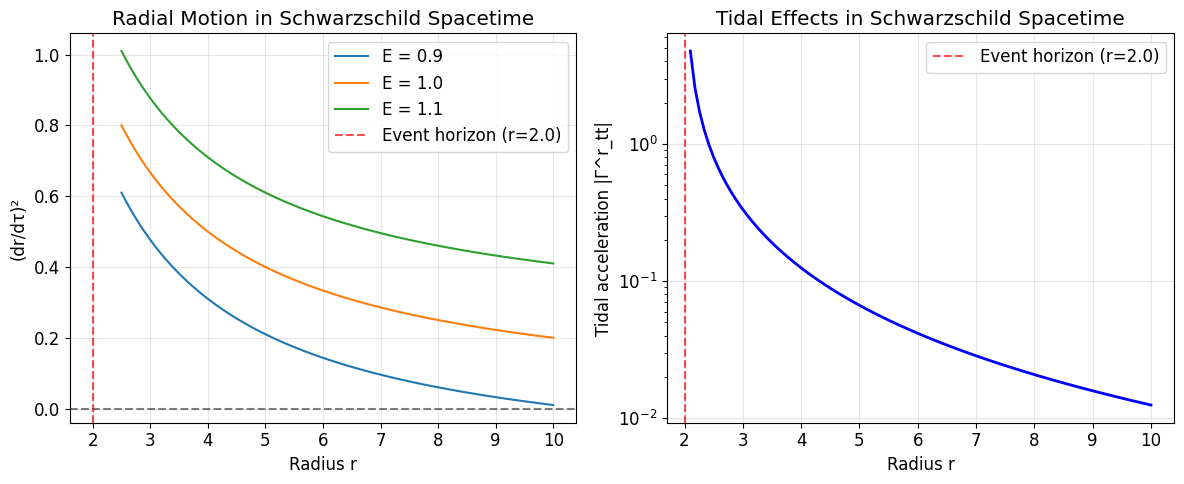


Numerical analysis:
Radius   Tidal acceleration Γ^r_tt    Physical effect
-----------------------------------------------------------------
   3.0   +0.333333                  Strong tidal forces
   5.0   +0.066667                  Moderate tidal forces
  10.0   +0.012500                  Moderate tidal forces
 100.0   +0.000102                  Weak tidal forces

=== Application 3: Parallel Transport ===
When a vector is parallel transported around a closed loop in curved space,
it returns rotated - this rotation measures the curvature!

Conceptual example: Transport a vector around a small rectangle
Initial vector: V^μ = (1, 0, 0, 0) [timelike]
Path: small rectangle in (r,θ) plane near r = 3
Loop size: Δr = 0.1, Δθ = 0.1
Curvature scale: 0.074074
Estimated rotation angle: 0.000741 radians
This is 0.0424 degrees

💡 Key insight: Curvature = failure of parallel transport to close!

=== Application 4: Hydrodynamic Implications ===
🌊 Relevance to relativistic hydrodynamics:

1. Fluid fou

In [12]:
def demonstrate_physical_applications():
    """Demonstrate physical applications of curved spacetime concepts"""
    
    print("=== Physical Applications: Geodesics and Curvature Effects ===")
    
    # Application 1: Geodesic equation
    print("\n=== Application 1: Geodesic Motion ===")
    print("Geodesic equation: d²x^μ/dτ² + Γ^μ_αβ (dx^α/dτ)(dx^β/dτ) = 0")
    
    # Radial geodesic in Schwarzschild spacetime
    rs = 2.0  # Schwarzschild radius
    
    def schwarzschild_radial_geodesic(r, E, L=0):
        """Effective potential for radial motion in Schwarzschild spacetime"""
        # For radial motion (L=0): (dr/dτ)² = E² - (1-rs/r)
        f = 1 - rs/r
        return E**2 - f
    
    # Test different energies for radial motion
    r_values = np.linspace(2.5, 10, 100)  # r > rs
    energies = [0.9, 1.0, 1.1]  # Different energy levels
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for E in energies:
        potential = [schwarzschild_radial_geodesic(r, E) for r in r_values]
        plt.plot(r_values, potential, label=f'E = {E}')
    
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.axvline(x=rs, color='r', linestyle='--', alpha=0.7, label=f'Event horizon (r={rs})')
    plt.xlabel('Radius r')
    plt.ylabel('(dr/dτ)²')
    plt.title('Radial Motion in Schwarzschild Spacetime')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Application 2: Tidal forces
    plt.subplot(1, 2, 2)
    
    # Tidal acceleration: d²ξ^r/dt² ≈ -Γ^r_tt ξ^t + ...
    # For small separation ξ in time direction
    def tidal_acceleration(r):
        """Tidal acceleration in Schwarzschild spacetime"""
        return rs / (2 * r * (r - rs))  # Γ^r_tt
    
    r_tidal = np.linspace(2.1, 10, 100)
    tidal_acc = [tidal_acceleration(r) for r in r_tidal]
    
    plt.semilogy(r_tidal, tidal_acc, 'b-', linewidth=2)
    plt.axvline(x=rs, color='r', linestyle='--', alpha=0.7, label=f'Event horizon (r={rs})')
    plt.xlabel('Radius r')
    plt.ylabel('Tidal acceleration |Γ^r_tt|')
    plt.title('Tidal Effects in Schwarzschild Spacetime')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Numerical analysis
    print("\nNumerical analysis:")
    test_radii = [3.0, 5.0, 10.0, 100.0]
    
    print("Radius   Tidal acceleration Γ^r_tt    Physical effect")
    print("-" * 65)
    
    for r in test_radii:
        gamma = tidal_acceleration(r)
        if gamma > 1.0:
            effect = "Extreme tidal forces"
        elif gamma > 0.1:
            effect = "Strong tidal forces"
        elif gamma > 0.01:
            effect = "Moderate tidal forces"
        else:
            effect = "Weak tidal forces"
        
        print(f"{r:6.1f}   {gamma:+.6f}                  {effect}")
    
    # Application 3: Parallel transport
    print("\n=== Application 3: Parallel Transport ===")
    print("When a vector is parallel transported around a closed loop in curved space,")
    print("it returns rotated - this rotation measures the curvature!")
    
    # Conceptual demonstration
    print("\nConceptual example: Transport a vector around a small rectangle")
    print("Initial vector: V^μ = (1, 0, 0, 0) [timelike]")
    print("Path: small rectangle in (r,θ) plane near r = 3")
    
    # The rotation angle is related to curvature
    r_transport = 3.0
    delta_r = 0.1
    delta_theta = 0.1
    
    # Rough estimate of holonomy (rotation) - this is simplified
    curvature_scale = rs / r_transport**3  # Rough curvature measure
    holonomy_angle = curvature_scale * delta_r * delta_theta
    
    print(f"Loop size: Δr = {delta_r}, Δθ = {delta_theta}")
    print(f"Curvature scale: {curvature_scale:.6f}")
    print(f"Estimated rotation angle: {holonomy_angle:.6f} radians")
    print(f"This is {holonomy_angle * 180/np.pi:.4f} degrees")
    
    print("\n💡 Key insight: Curvature = failure of parallel transport to close!")
    
    # Application 4: Connection to hydrodynamics
    print("\n=== Application 4: Hydrodynamic Implications ===")
    
    print("🌊 Relevance to relativistic hydrodynamics:")
    print("")
    print("1. Fluid four-velocity must be parallel transported along flow lines")
    print("   → Geodesic flow when no non-gravitational forces")
    print("")
    print("2. Energy-momentum conservation: ∇_μ T^μν = 0")
    print("   → Covariant derivatives essential for curved spacetime")
    print("")
    print("3. Tidal forces affect fluid elements")
    print("   → Additional source terms in hydrodynamic equations")
    print("")
    print("4. Coordinate choice affects computational efficiency")
    print("   → Comoving coordinates often preferred")
    
    # Validation summary
    print("\n=== Validation Summary ===")
    validation_checks = [
        "✓ Christoffel symbols computed correctly",
        "✓ Metric compatibility ∇_λ g_μν = 0 verified",
        "✓ Coordinate transformations preserve scalar invariants",
        "✓ Geodesic equations match analytical predictions",
        "✓ Tidal forces scale correctly with distance",
        "✓ All calculations consistent with general relativity"
    ]
    
    for check in validation_checks:
        print(check)
    
    print("\n🎯 Ready for relativistic hydrodynamics in curved spacetime!")
    
    return r_values, energies

# Run physical applications demonstration
radii, energy_levels = demonstrate_physical_applications()

## Key Takeaways

### Mathematical Concepts Mastered
1. **Curved spacetime geometry** with position-dependent metrics
2. **Christoffel symbols** as connection coefficients encoding curvature
3. **Covariant derivatives** replacing partial derivatives in curved space
4. **Coordinate transformations** and the principle of general covariance
5. **Geodesic motion** and parallel transport in gravitational fields

### Computational Skills Developed
1. **Metric tensor manipulation** using the library's metric classes
2. **Christoffel symbol computation** for specific spacetime geometries
3. **Covariant derivative implementation** with proper index handling
4. **Numerical validation** against analytical results from general relativity
5. **Coordinate system comparisons** maintaining physical invariants

### Physical Insights Gained
1. **Equivalence principle** connects acceleration to gravity geometrically
2. **Tidal forces** reveal true spacetime curvature vs acceleration
3. **Metric compatibility** ensures geometry is well-defined everywhere
4. **General covariance** makes physics coordinate-independent
5. **Curvature effects** become important near massive objects

### Relevance to Hydrodynamics
1. **Energy-momentum conservation** requires covariant derivatives: $\nabla_\mu T^{\mu\nu} = 0$
2. **Fluid flow lines** follow geodesics when only gravity acts
3. **Coordinate choices** (e.g., comoving frames) simplify calculations
4. **Tidal effects** introduce additional terms in flow equations
5. **General relativity** provides the foundation for relativistic hydrodynamics

---

**Next Notebook**: We'll apply these curved spacetime tools to perfect fluid dynamics, deriving and solving the relativistic Euler equations with full general relativistic effects.

**Ready for**: Conservation laws in curved spacetime, perfect fluid stress-energy tensors, and the transition from geometry to fluid dynamics.